In [32]:
import torch.nn as nn
import torch
import random
# Define the model
# torch.manual_seed(42)

prob = 0.99
size = 10
z1 = torch.randn(size,768)
z2 = torch.randn(size,768)
labels = torch.randint(0,2,(size,1))
cos = nn.CosineSimilarity(dim=-1)
cos_sim = cos(z1.unsqueeze(1),z2.unsqueeze(0))
labelss = torch.arange(cos_sim.size(0)).long()


mask = torch.bernoulli(torch.ones(size) * prob).int() # 生成一个0或1的张量


pos_idx = torch.nonzero(labels == 1)[:,0]
neg_idx = torch.nonzero(labels == 0)[:,0]

pos_random_index = torch.randint(0, pos_idx.size()[0], (size,))

pos_random_element = pos_idx[pos_random_index]

# print(neg_idx)
# print(mask)
# mask[neg_idx] = 0
# print(mask)



# labelss[mask==1] = pos_random_element[mask==1]
# print(labelss)
# labelss[2] = 5
print(labels.view(-1))
print(labelss)


for i in range(labelss.size(0)):
    hit = torch.bernoulli(torch.tensor(prob)).int() # 生成一个0或1的张量
    if hit == 1:
        if labels[i] == 1:
            labelss[i] = pos_idx[torch.randint(0, pos_idx.size()[0],(1,))]
        if labels[i] == 0:
            labelss[i] = neg_idx[torch.randint(0, neg_idx.size()[0],(1,))]
            
print(labelss)


tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([2, 2, 1, 1, 4, 8, 6, 6, 5, 8])


In [2]:
import pandas as pd
res = pd.read_csv('/home/linzhisheng/Digital_Research/reddit.csv')
res = res[res['prompt_label'] == 1]
res

,id,full_text,prompt_label
0,t3_12n5ol5,Does It Bother You That The Top 2% Of Wallets ...,1
2,t3_12bsvdw,You wake up one day and Bitcoin is trading ove...,1
4,t3_12qiks2,"With one year left to the next halving, Bitcoi...",1
5,t3_11x0in7,Bitcoin breaking 50 and 200 moving avarg on th...,1
7,t3_13ifn2t,Bitcoin is a bubble with 'no inherent value an...,1
...,...,...,...
1161,t3_13bdadf,Bitcoin is demonetizing gold\n,1
1166,t3_13bavcf,P2P Marketplace Paxful Returns To Normal Opera...,1
1175,t3_13b158a,Why are the fees so much higher on my Ledger n...,1
1177,t3_13b3ymi,Why are blocks not 4MB in size?\nAccording to ...,1


In [1]:
# 对比学习过滤post
from transformers import AutoModel, AutoTokenizer,AutoConfig
from torch.utils.data import DataLoader
import torch
import pandas as pd
import json
from datasets import *
from typing import Optional, Union, List, Dict, Tuple
from dataclasses import dataclass, field
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score
import numpy as np


MODEL_PATH = '/home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0'
DEVICE = torch.device('cuda:0')
MAX_LENGTH = 32
BATCH_SIZE = 64

model = AutoModel.from_pretrained(MODEL_PATH).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# print(model)

def process_date(example):
    
    sent_features = tokenizer(
        example['full_text'],
        padding=True,
    )
    return sent_features


def main(): 
    train_data = load_dataset('csv', data_files='/home/linzhisheng/Digital_Research/filter_model/data/filter_model_data.csv',split='train')
    eval_data = pd.read_csv('/home/linzhisheng/Digital_Research/result.csv')
    
        
    print(train_data)
    print(eval_data)
    
    train_data = train_data.select(range(88))
    train_labels = train_data["label"]
    train_texts = train_data["full_text"]
    train_inputs = tokenizer(train_texts, padding=True,max_length = MAX_LENGTH,
                        truncation=True, return_tensors="pt").to(DEVICE)

    eval_data["full_text"] = eval_data["full_text"].astype(str)
    # eval_data["id"] = eval_data["id"].astype(str)
    # eval_data["day"] = eval_data["day"].astype(str)
    # eval_data["created_at"] = eval_data["created_at"].astype(str)
    # eval_data['label'] = ''
    texts = eval_data["full_text"].to_list()
    # ids = eval_data["id"].to_list()
    # period = eval_data["day"].to_list()
    # create = eval_data["created_at"].to_list()
    eval_data['label'] = 0
    batchs = [texts[i*BATCH_SIZE:(i+1)*BATCH_SIZE] for i in range(int(len(texts)/BATCH_SIZE))]
    # id_batchs = [ids[i*BATCH_SIZE:(i+1)*BATCH_SIZE] for i in range(int(len(texts)/BATCH_SIZE))]
    # period_batchs = [period[i*BATCH_SIZE:(i+1)*BATCH_SIZE] for i in range(int(len(texts)/BATCH_SIZE))]
    # create_batchs = [create[i*BATCH_SIZE:(i+1)*BATCH_SIZE] for i in range(int(len(texts)/BATCH_SIZE))]
    
    model.eval()
    with torch.no_grad():
        base_embeddings = model(**train_inputs, output_hidden_states=True,
                                return_dict=True).last_hidden_state[:, 0].cpu()
    pos_idx = [idx for idx, label in enumerate(train_labels) if label == 1]
    neg_idx = [idx for idx, label in enumerate(train_labels) if label == 0]
    pos_anchor = torch.mean(base_embeddings[pos_idx],dim=0,keepdim=True)
    neg_anchor = torch.mean(base_embeddings[neg_idx],dim=0,keepdim=True)
    print('anchor shape',pos_anchor.shape)
    
    res = []
    for id,batch in enumerate(batchs):
        print(id,len(batchs))
        inputs = tokenizer(batch, padding=True,
            truncation=True, return_tensors="pt").to(DEVICE)
        
        model.eval()
        with torch.no_grad():
            embeddings = model(**inputs, output_hidden_states=True,
                                return_dict=True).last_hidden_state[:, 0].cpu()
        pos_cos_sim = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(1), pos_anchor.unsqueeze(0), dim=-1)
        neg_cos_sim = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(1), neg_anchor.unsqueeze(0), dim=-1)
        for i in range(len(batch)):
            if pos_cos_sim[i][0] >= neg_cos_sim[i][0]:
                # print(id*BATCH_SIZE+i)
                eval_data.at[id*BATCH_SIZE+i,'label'] = 1
                # res.append([id_batchs[id][i],batch[i],period_batchs[id][i], create_batchs[id][i]])
        
        # print(len(res))
        # break

    # # 设置列名
    # columns = ["id", "full_text","date","created_at"]
    # # 创建DataFrame对象
    # df = pd.DataFrame(res, columns=columns)
    # df["label1"] = ''
    # df["label2"] = ''
    # print(df)
    # df.to_csv('tweets_sample_2020_2023_filter.csv',index=False)

    print(eval_data)
    eval_data.to_csv('result_filter.csv',index=False)


    
if __name__ == '__main__':
    main()

Some weights of the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0 were not used when initializing BertModel: ['mlp.dense.bias', 'mlp.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using custom d

Dataset({
    features: ['full_text', 'label'],
    num_rows: 89
})
                         id  \
0       1344858843767922688   
1       1344871001113333768   
2       1345012337477103618   
3       1345054993129340929   
4       1345056010981892096   
...                     ...   
666028  1665585237022199809   
666029  1665633896594124800   
666030  1665685201190629376   
666031  1665703162597244929   
666032  1666022118239137793   

                                                full_text  \
0                       What was your best trade of 2020?   
1       🥳🎉 HAPPY NEW YEAR 🥳🎉\n\nTo celebrate, $100 #bi...   
2       Give me $1 for 74 cents!\n\nSo Tether calls it...   
3       #Cardano 2020 Review\n\nExtended version with ...   
4       #Bittrex Customers:  \n\nThe $XMR, $ZEC, and $...   
...                                                   ...   
666028  GM ☀️\n\nLet's make this a month of exciting o...   
666029  Tune in at 10am UTC on June 6th for the premie...   
666030  Di

In [ ]:
# prompt过滤post








In [4]:
# 去重

# 过滤post
from transformers import AutoModel, AutoTokenizer,AutoConfig
from torch.utils.data import DataLoader
import torch
import pandas as pd
import json
from datasets import *
from typing import Optional, Union, List, Dict, Tuple
from dataclasses import dataclass, field
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score
import numpy as np
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset



MODEL_PATH = '/home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0'
DEVICE = torch.device('cuda:0')
# MAX_LENGTH = 32
# BATCH_SIZE = 64

model = AutoModel.from_pretrained(MODEL_PATH).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# print(model)


def process_date(example):
    str_list = list(map(str, example['full_text']))
    sent_features = tokenizer(
        str_list,
        truncation=True,
        max_length = 512,
        padding="max_length",
    )
    return sent_features

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def main(): 
    datas = load_dataset('csv', data_files='tweets_sample_2020_2023_filter.csv',split='train')
    datas = datas.select(range(1000))
    str_list = list(map(str, datas['full_text']))
    inputs = tokenizer(str_list, padding=True,
                        truncation=True, return_tensors="pt").to(DEVICE)

    data = []
    for i in range(len(inputs['input_ids'])):
        data.append({key:inputs[key][i] for key in inputs})

    dataloader = DataLoader(data, batch_size=64, shuffle=False)
    embeddings = []
    for idx,batch in enumerate(dataloader):
        model.eval()
        with torch.no_grad():
            sentence_embeddings = model(**batch, output_hidden_states=True,
                                return_dict=True).last_hidden_state[:, 0].cpu()
            # model_output = model(**batch)
            # sentence_embeddings = mean_pooling(model_output, batch['attention_mask'])

            # sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1).cpu()

            
            embeddings.append(sentence_embeddings)
            # print(sentence_embeddings.shape)

    
    embeddings = torch.cat(embeddings, dim=0)
    
    
    cos_sim = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1)
    # print(cos_sim)
    for i in range(cos_sim.size(0)):
        for j in range(cos_sim.size(1)):
            if i==j:
                continue
            if cos_sim[i][j] >= 0.8:
                print(cos_sim[i][j])
                print('1. ',datas[i]['full_text'])
                print('2. ',datas[j]['full_text'])
                print('=============================================================')

    


    
if __name__ == '__main__':
    main()

Some weights of the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0 were not used when initializing BertModel: ['mlp.dense.bias', 'mlp.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE/result/bert-base-uncased-p-0 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using custom d

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_10581/1635818274.py:94 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_10581/1635818274.py'                        │
│                                                                                                  │
│ /tmp/ipykernel_10581/1635818274.py:77 in main                                                    │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_10581/1635818274.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [6]:
from sentence_transformers import SentenceTransformer, util
from datasets import *
sentences = [
    '''Smart money's moving in. Gold is legendary investor/speculator Paul Tudor Jones' favorite trade for next 12-24 mos. "If it goes to $1400, it goes to $1700 rather quickly." "It has everything going for it." In recessionary environment with rates near zero- "gold's going to scream"
''',
    '''The Ugly 2020 Bitcoin Outlook is now available.  Sorry, no more freebies.  However, you can get a 15% discount by using the affiliate code link of an existing Lifetime Member. https://t.co/V5ZZOkUMIo
'''
    ]
datas = load_dataset('csv', data_files='tweets_sample_2020_2023_filter.csv',split='train')
datas = datas.select(range(1000))
str_list = list(map(str, datas['full_text']))

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device='cuda:0')


#Compute embedding for both lists
# embedding_1= model.encode(sentences[0], convert_to_tensor=True)
# embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embeddings = model.encode(sentences, convert_to_tensor=True)
# util.pytorch_cos_sim(embedding_1, embedding_2)
# print(embeddings.shape)
cos_sim = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(1),embeddings.unsqueeze(0), dim=-1)
cos_sim
# for i in range(1000):
#     for j in range(1000):
#         if i==j:
#             continue
#         if cos_sim[i][j] >= 0.8:
#             cos_sim[j][i] = 0
#             print(cos_sim[i][j])
#             print('1. ',datas[i]['full_text'])
#             print('2. ',datas[j]['full_text'])
#             print('=============================================================')

Using custom data configuration default-353bc4e358593990
Found cached dataset csv (/home/linzhisheng/.cache/huggingface/datasets/csv/default-353bc4e358593990/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


tensor([[1.0000, 0.2541],
        [0.2541, 1.0000]], device='cuda:1')

In [4]:
import pandas as pd
from datasets import *
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score
import numpy as np
input = pd.read_csv('/home/linzhisheng/Digital_Research/filter_model/data/filter_model_manual_400.csv')

preds_np = np.array(input['chat_label'].tolist())
labels_np = np.array(input['label'].tolist())
print(input['chat_label'].value_counts())

f1 = f1_score(labels_np, preds_np)
precision = precision_score(labels_np, preds_np)
recall = recall_score(labels_np, preds_np)
accuracy = accuracy_score(labels_np, preds_np)
print(f"F1-score: {f1:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"Accuracy: {accuracy:.5f}")


1    241
0    159
Name: chat_label, dtype: int64
F1-score: 0.67849
Precision: 0.63485
Recall: 0.72857
Accuracy: 0.63750


In [16]:
import random
train_labels = [0,1,1,0]
lst = [random.randint(0, len(train_labels)-1) for _ in range(len(train_labels))]
print(lst)
lst = [random.randint(0, len(train_labels)-1) for _ in range(len(train_labels))]
print(lst)

[2, 1, 3, 3]
[2, 1, 3, 2]


In [37]:
import torch.nn.functional as F
import torch

criterion = torch.nn.BCEWithLogitsLoss()
pred = torch.tensor([[0, 0, 0],[1,1,1]],  dtype=torch.float)  # 模型输出的预测得分
true_label = torch.tensor([[0, 0, 0],[1,1,1]], dtype=torch.float)  # 真实标签
loss = criterion(pred.view(1, -1), true_label.view(1, -1))  # 计算多标签交叉熵损失
print(loss)  # tensor(0.4821)

a = torch.tensor([[1],[0],[1],[1]])
a.size(0)
b = torch.eq(a.view(a.size(0),1), a.view(1,a.size(0))).int()
print(b)


a = torch.tensor([1,0,1,1])


tensor(0.5032)
tensor([[1, 0, 1, 1],
        [0, 1, 0, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 1]], dtype=torch.int32)


In [42]:
import torch
z1 = torch.randn(200,768)
z2 = torch.randn(200,768)
a = [2,4,6]
z1 = z1[a]

print(z1.shape)

an = torch.mean(z1,dim=0,keepdim=True)
print(an.shape)


b = torch.nn.functional.cosine_similarity(z1.unsqueeze(1), an.unsqueeze(0), dim=-1)
b[0][0]
# cos = torch.nn.CosineSimilarity(dim=-1)
# print(cos(z1.unsqueeze(1),z2.unsqueeze(0)))

torch.Size([3, 768])
torch.Size([1, 768])


tensor(0.5927)

Some weights of BertModel were not initialized from the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE-main/result/my-sup-simcse-bert-base-uncased-test and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Topic  Size
1      1    32
0      0    22
1: [('breaking', 0.03672139095879898), ('000', 0.03390778668728734), ('payments', 0.032131971425239304), ('https', 0.028522526729484212), ('time', 0.02676270146200152)]
0: [('twitter', 0.04558517498333666), ('know', 0.03988796452788328), ('https', 0.03835788077413394), ('crypto', 0.03432489404651446), ('btc', 0.03322266388386396)]


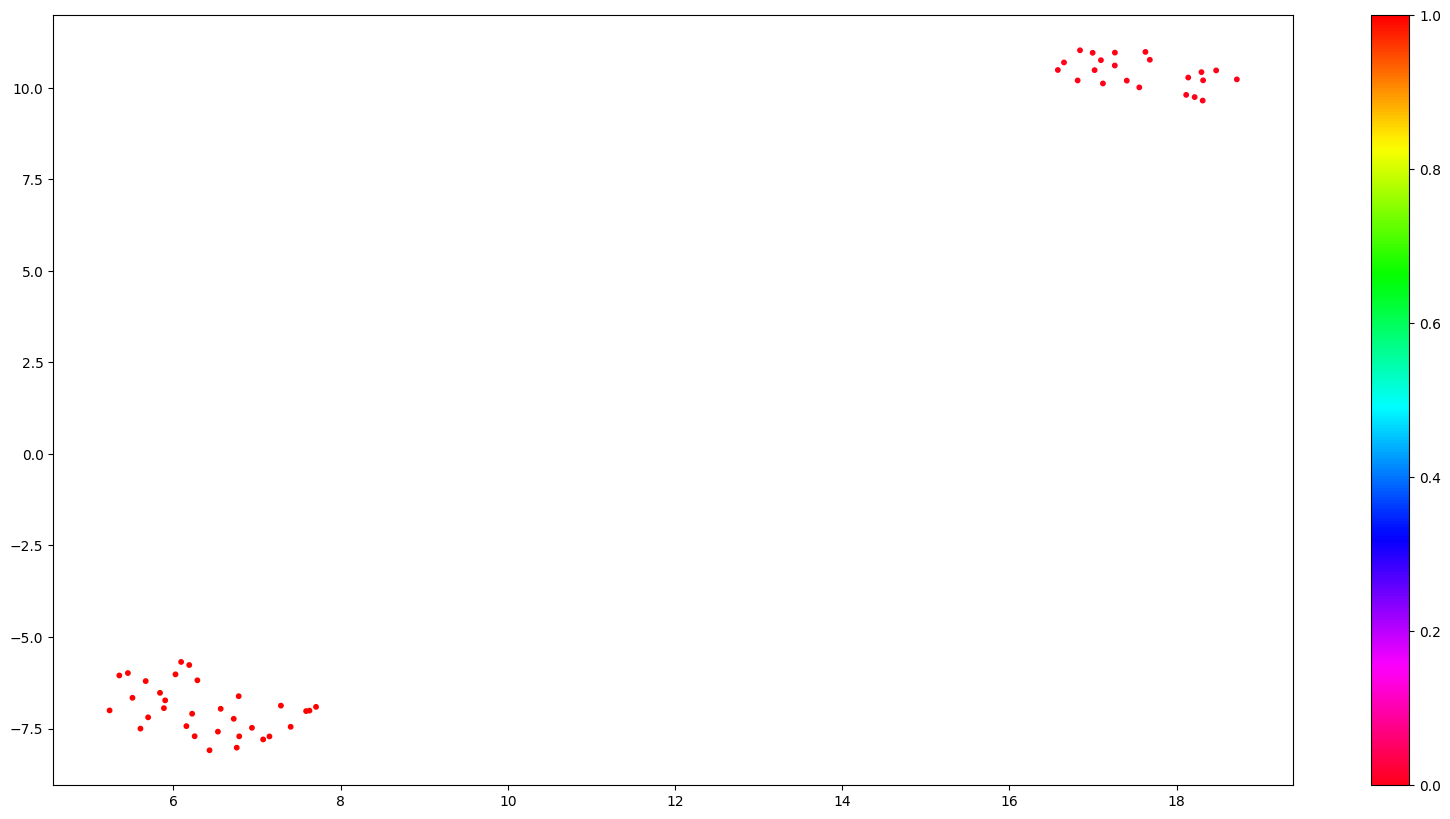

In [44]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
from transformers import pipeline
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings
import pandas as pd
import torch
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def cluster_model(input, output, min_cluster_size, embeddings):
    # embeddings = model.encode(input, show_progress_bar=True)
    # model = AutoModelForMaskedLM.from_pretrained(local)
    # feature_pipeline = pipeline('feature-extraction', model=model, tokenizer = tokenizer)
    # embeddings = feature_pipeline(['good', 'bad'])
    # model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    import umap
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                                n_components=2, 
                                metric='cosine').fit_transform(embeddings)
    import hdbscan
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            metric='euclidean',                      
                            cluster_selection_method='eom').fit(umap_embeddings)
    
    import matplotlib.pyplot as plt

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
    plt.colorbar()
    plt.savefig(output)
    
    
    docs_df = pd.DataFrame(input, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(input))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
    topic_sizes = extract_topic_sizes(docs_df)
    print(topic_sizes.head(10))
    for t in topic_sizes.head(10)['Topic']:
        print(f"{t}: {top_n_words[t]}")
        

data = pd.read_csv(
    '/home/linzhisheng/Digital_Research/filter_model/data/label_tweets.csv')
# data2 = pd.read_csv(
    # '/home/linzhisheng/Digital_Research/filter_model/data/filter_model_validate_set.csv')
# data = pd.concat([data, data2], ignore_index=True)
texts = data["full_text"].tolist()


MODEL_PATH = '/home/linzhisheng/Digital_Research/SimCSE-main/result/my-unsup-simcse-bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
device = 'cuda:0'
model = AutoModel.from_pretrained(MODEL_PATH).to(device)
inputs = tokenizer(texts, padding=True,
                   truncation=True, return_tensors="pt").to(device)
# # Get the embeddings
with torch.no_grad():
    embeddings = model(**inputs, output_hidden_states=True,
                       return_dict=True).pooler_output.cpu()
    
cluster_model(texts, 'test', 2, embeddings)



In [27]:
topic_model.get_topic(0)

False

In [28]:
topic_model.visualize_topics()

IndexError: arrays used as indices must be of integer (or boolean) type

In [29]:
topic_model.visualize_barchart(top_n_topics=8)

ValueError: 
The 'rows' argument to make_suplots must be an int greater than 0.
    Received value of type <class 'int'>: 0

In [30]:
topic_model.visualize_hierarchy(top_n_topics=50)

ValueError: Found array with 0 sample(s) (shape=(0, 891)) while a minimum of 1 is required by check_pairwise_arrays.